Importing the necessary libraries

In [110]:
import pandas as pd
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',50)
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,f1_score,recall_score
from sklearn.neighbors import KNeighborsClassifier

import random
import string
import missingno

from feature_engine.encoding import WoEEncoder,RareLabelEncoder

Data Cleaning

In [47]:
df = pd.read_csv('Train_Set_TVS.csv')
df.set_index('ID',inplace=True)

In [50]:
test_df = pd.read_csv('Test_Set_TVS.csv')
test_df.set_index('ID',inplace=True)

In [51]:
Nulls = pd.DataFrame({'Nulls':df.isnull().sum(),'Null%':(df.isnull().sum()/df.count())*100,'Datatype':df.dtypes,'Variance':df.var()})
Nulls[Nulls['Nulls']>0]

,Nulls,Null%,Datatype,Variance
Annuity_amt,4611,3.607163,float64,4.249903e+06
Company_Rating,11731,9.718414,float64,2.537638e-01
Compensation,6242,4.946196,float64,2.211597e+11
Contact_age,8153,6.559817,float64,6.882896e+05
Credit_Inq,2690,2.073218,object,NaN
Experience,21845,19.752249,float64,4.041214e+01
Home_Appliances,10964,9.025651,float64,1.541945e+00
Income_Alt,7682,6.157521,object,NaN
Job_Type,10248,8.386801,object,NaN
Prop_List,1965,1.506036,object,NaN


I'm splitting the train data further into train and test data, to compare the quality of models, to evaluate them. I plan to use the final model on the actual test data.

Splitting the data into train and test:

In [52]:
X = df.drop(columns=['Default'],axis=1)
y = df['Default']

X_train,X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=100)

In [70]:
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of y_train is {y_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of y_test is {y_test.shape}')

The shape of X_train is (105952, 31)
The shape of y_train is (105952,)
The shape of X_test is (26488, 31)
The shape of y_test is (26488,)


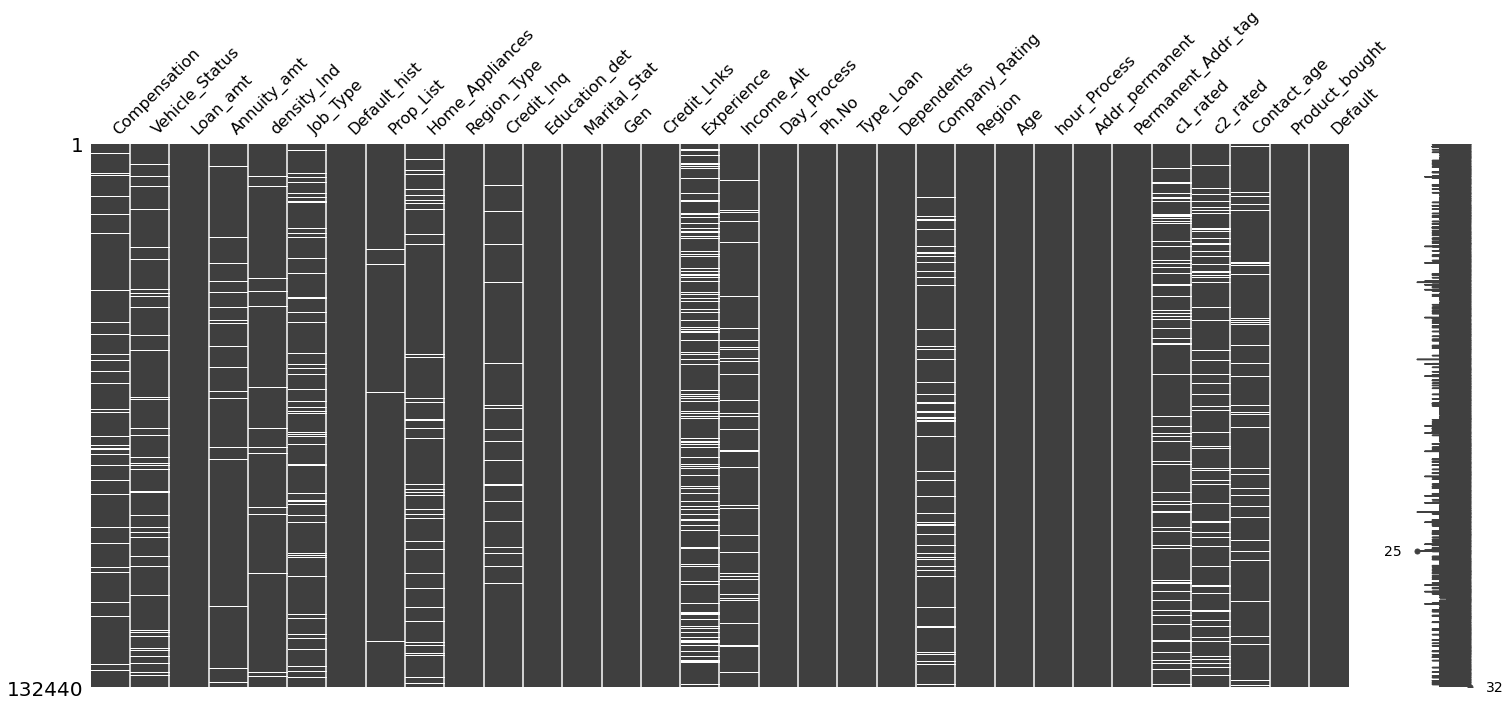

In [53]:
missingno.matrix(df)
plt.show()

We can see that there are a lot of null values present in these variables. Since they are less than ~20 %, we can impute them.

I'm planning to employ the IQR imputation technique for numerical variables, and proportional imputation for cateogrical variables to preserve the distribution of the data.

I'm defining functions to shorten the time consumed for imputing each and every column manually.

In [54]:
#Function for imputing numerical variables:

def impute_float(X,j,interval,rnd_vlue):
    Q1 = X[j].quantile(0.25)
    Q3 = X[j].quantile(0.75)
    IQR = Q3-Q1
    Max = Q3 + 1.5*IQR
    Min = Q1 - 1.5*IQR
    for i in X[X[j].isnull()].index:
        X[j][i] = round(random.choice(list(np.arange(Min,Max,interval))),rnd_vlue)

#Function for imputing categorical variables:
        
def impute_cat(X,j):
    n = X[j].isnull().sum()
    y = X[j].value_counts(normalize=True)
    length = len(y)
    alph = list(string.ascii_lowercase)
    big_list = []
    for n,i in enumerate(alph[:length]):
        locals()[i] = [y.keys()[n]]*round(y[n]*100)
        big_list.extend(locals()[i])
    for i in X[X[j].isnull()].index:
        X[j][i] = random.choice(big_list)

In [55]:
Nulls[(Nulls['Nulls']>0) & (Nulls['Datatype'] == 'float64')]

,Nulls,Null%,Datatype,Variance
Annuity_amt,4611,3.607163,float64,4.249903e+06
Company_Rating,11731,9.718414,float64,2.537638e-01
Compensation,6242,4.946196,float64,2.211597e+11
Contact_age,8153,6.559817,float64,6.882896e+05
Experience,21845,19.752249,float64,4.041214e+01
Home_Appliances,10964,9.025651,float64,1.541945e+00
c1_rated,17513,15.238369,float64,7.218069e-02
c2_rated,13321,11.182935,float64,7.220803e-02
density_Ind,5416,4.263761,float64,2.273055e-04


In [ ]:
#Imputing for the train data
impute_float(X_train,'Compensation',0.5,1)
impute_float(X_train,'Annuity_amt',0.23,2)
impute_float(X_train,'density_Ind',0.23,4)
impute_float(X_train,'Experience',0.1,1)
impute_float(X_train,'c1_rated',0.37,3)
impute_float(X_train,'c2_rated',0.23,3)
impute_float(X_train,'Contact_age',1,0)

In [56]:
#Imputing for the test data
impute_float(X_test,'Compensation',0.5,1)
impute_float(X_test,'Annuity_amt',0.23,2)
impute_float(X_test,'density_Ind',0.23,4)
impute_float(X_test,'Experience',0.1,1)
impute_float(X_test,'c1_rated',0.37,3)
impute_float(X_test,'c2_rated',0.23,3)
impute_float(X_test,'Contact_age',1,0)

#I'm considering home appliances and company ratings as categorical variables

In [32]:
Nulls[(Nulls['Nulls']>0) & (Nulls['Datatype'] == 'object')]

,Nulls,Null%,Datatype,Variance
Credit_Inq,2690,2.073218,object,NaN
Income_Alt,7682,6.157521,object,NaN
Job_Type,10248,8.386801,object,NaN
Prop_List,1965,1.506036,object,NaN
Vehicle_Status,9104,7.381462,object,NaN


In [ ]:
#Imputing for train data

impute_cat(X_train,'Vehicle_Status')
impute_cat(X_train,'Job_Type')
impute_cat(X_train,'Prop_List')
impute_cat(X_train,'Credit_Inq')
impute_cat(X_train,'Income_Alt')

X_train['Company_Rating'].replace({1:'One',2:'Two',3:'Three'},inplace=True)
impute_cat(X_train,'Company_Rating')
X_train['Company_Rating'].replace({'One':1,'Two':2,'Three':3},inplace=True)


X_train['Home_Appliances'].replace({1:'One',2:'Two',3:'Three',4:'Four',
                                    5:'Five',6:'Six',7:'Seven',8:'Eight',
                                    9:'Nine',10:'Ten',12:'Twelve',14:'Fourteen',19:'Nineteen'},inplace=True)
impute_cat(X_train,'Home_Appliances')
X_train['Home_Appliances'].replace({'One':1,'Two':2,'Three':3,'Four':4,
                                    'Five':5,'Six':6,'Seven':7,'Eight':8,
                                    'Nine':9,'Ten':10,'Twelve':12,'Fourteen':14,'Nineteen':19},inplace=True)

In [57]:
# Imputing for test data

impute_cat(X_test,'Vehicle_Status')
impute_cat(X_test,'Job_Type')
impute_cat(X_test,'Prop_List')
impute_cat(X_test,'Credit_Inq')
impute_cat(X_test,'Income_Alt')


X_test['Company_Rating'].replace({1:'One',2:'Two',3:'Three'},inplace=True)
impute_cat(X_test,'Company_Rating')
X_test['Company_Rating'].replace({'One':1,'Two':2,'Three':3},inplace=True)

X_test['Home_Appliances'].replace({1:'One',2:'Two',3:'Three',4:'Four',
                                    5:'Five',6:'Six',7:'Seven',8:'Eight',
                                    9:'Nine',10:'Ten',12:'Twelve',14:'Fourteen',19:'Nineteen'},inplace=True)

impute_cat(X_test,'Home_Appliances')

X_test['Home_Appliances'].replace({'One':1,'Two':2,'Three':3,'Four':4,
                                    'Five':5,'Six':6,'Seven':7,'Eight':8,
                                    'Nine':9,'Ten':10,'Twelve':12,'Fourteen':14,'Nineteen':19},inplace=True)

In [ ]:
missingno.matrix(X_train)

We can see that there are no null values present.

We'll perform the encoding now.

Encoding the bi-class variables:

In [43]:
two_features = []
for i in X.columns:
    if X[i].nunique() ==2:
        print(f'{i} - {X[i].unique()}')
        two_features.append(i)

Vehicle_Status - ['Y' 'N' nan]
Default_hist - ['ndf' 'df']
Gen - ['F' 'M']
Income_Alt - ['Not_Specified' 'Y' nan]
Ph.No - ['Yes' 'No']
Type_Loan - ['CLoan' 'RLoan']
Addr_permanent - ['Yes' 'No']
Permanent_Addr_tag - ['No' 'Yes']


In [ ]:
#Encoding Train data

X_train['Vehicle_Status'].replace({'N':0,'Y':1},inplace=True)
X_train['Default_hist'].replace({'ndf':0,'df':1},inplace=True)
X_train['Gen'].replace({'M':0,'F':1},inplace=True)
X_train['Income_Alt'].replace({'Not_Specified':0,'Y':1},inplace=True)
X_train['Ph.No'].replace({'No':0,'Yes':1},inplace=True)
X_train['Type_Loan'].replace({'CLoan':0,'RLoan':1},inplace=True)
X_train['Addr_permanent'].replace({'No':0,'Yes':1},inplace=True)
X_train['Permanent_Addr_tag'].replace({'No':0,'Yes':1},inplace=True)

In [58]:
#Encoding test data

X_test['Vehicle_Status'].replace({'N':0,'Y':1},inplace=True)
X_test['Default_hist'].replace({'ndf':0,'df':1},inplace=True)
X_test['Gen'].replace({'M':0,'F':1},inplace=True)
X_test['Income_Alt'].replace({'Not_Specified':0,'Y':1},inplace=True)
X_test['Ph.No'].replace({'No':0,'Yes':1},inplace=True)
X_test['Type_Loan'].replace({'CLoan':0,'RLoan':1},inplace=True)
X_test['Addr_permanent'].replace({'No':0,'Yes':1},inplace=True)
X_test['Permanent_Addr_tag'].replace({'No':0,'Yes':1},inplace=True)

In [44]:
multi_features = list(set(X.select_dtypes('O').columns) - set(two_features))
multi_features

['Credit_Lnks',
 'Job_Type',
 'Marital_Stat',
 'Region_Type',
 'Prop_List',
 'Education_det',
 'Credit_Inq',
 'Day_Process',
 'Region']

I'm planning to use Weight of Evidence Encoding for all the multi-label columns, since this is a classification problem , and we have a significant number of datapoints in the train data to understand which labels are more concerned with the class 1 and class 0 of the default class. Prior to that, we'll use rare encoder to reduce cardinality.

In [ ]:
rare_encoder = RareLabelEncoder(tol=0.03,
                                n_categories=2, 
                                variables=['Job_Type', 'Prop_List', 'Region_Type','Credit_Inq','Education_det','Credit_Lnks',
                                          'Region','Day_Process','Marital_Stat'])

rare_encoder.fit(X_train)
train_t = rare_encoder.transform(X_train)


woe_enc = WoEEncoder(variables=['Job_Type', 'Prop_List', 'Region_Type','Credit_Inq','Education_det','Credit_Lnks',
                                          'Region','Day_Process','Marital_Stat'])
woe_enc.fit(train_t, y_train)
train_t = woe_enc.transform(train_t)
X_train = train_t

In [75]:
X_train.head()

,Compensation,Vehicle_Status,Loan_amt,Annuity_amt,density_Ind,Job_Type,Default_hist,Prop_List,Home_Appliances,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Experience,Income_Alt,Day_Process,Ph.No,Type_Loan,Dependents,Company_Rating,Region,Age,hour_Process,Addr_permanent,Permanent_Addr_tag,c1_rated,c2_rated,Contact_age,Product_bought
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
577876,247419.0,1,62286.00,6099.55,0.0109,0.002915,0,0.018021,1,0.004843,0.027383,0.018343,0.018117,0,-0.007628,1.1,1,0.001402,1,0,3,2,0.054513,45,14,1,1,0.771,0.771,14,2
527271,793299.0,0,410319.35,9025.54,-0.0196,0.002915,0,-0.005376,4,-0.042799,-0.004263,0.018343,-0.001260,0,-0.007628,0.9,0,0.013187,0,0,2,2,0.054513,55,13,1,0,0.725,0.725,1610,3
432768,910260.0,1,152340.00,9922.07,0.0320,0.002915,0,0.018021,1,0.004843,-0.070121,0.018343,-0.001260,1,-0.007628,3.4,0,0.021524,1,0,3,2,-0.007106,33,11,1,1,0.561,0.561,1114,4
464685,580260.0,0,810558.00,12226.28,0.0123,-0.009248,0,-0.005376,4,-0.042799,-0.070121,0.018343,-0.001260,0,-0.007628,2.4,1,0.001402,1,0,2,2,-0.017584,62,8,1,1,0.783,0.783,1627,6
575078,552928.0,0,327972.60,11179.04,0.0175,0.002915,0,-0.005376,2,0.004843,-0.013010,0.018343,-0.001260,0,-0.007628,10.2,0,0.013187,1,0,2,3,-0.007106,30,12,0,0,0.811,0.811,248,2


In [59]:
#We replace the values gotten into the categories of the X_test.

X_test['Job_Type'].replace({'IT':0.002915,'Non-IT':-0.009248,'Govt.':0.002956},inplace=True)
X_test['Prop_List'].replace({'One':-0.005376,'Morethan_One':0.018021,'None':0.001903},inplace=True)
X_test['Region_Type'].replace({'Metro':0.004843,'Rural':-0.018632,'other':-0.042799},inplace=True)
X_test['Credit_Inq'].replace({'1':0.027383,'2':-0.004263,'3':-0.070121 ,'>4':-0.013010},inplace=True)
X_test['Education_det'].replace({'Grad':0.018343,'P_Grad':-0.064172,'Other':0.050836},inplace=True)
X_test['Credit_Lnks'].replace({'1_to_3':-0.007628,'4_to_6':0.078556,'>6':-0.095409},inplace=True)
X_test['Region'].replace({'North':-0.017584,'East':-0.007106,'Central':-0.005934,'South':0.054513},inplace=True)
X_test['Day_Process'].replace({'Tue':-0.010428,'wed':0.001402,'mon':0.013187,'thur':-0.005112,'Fri':-0.009343,'SAT': 0.021524,'Sun':-0.011897},inplace=True)
X_test['Marital_Stat'].replace({'Married':-0.001260,'Single':0.018117,'Divorce':-0.014039,'Widow':0.050957},inplace=True)


In [60]:
X_test.head()

,Compensation,Vehicle_Status,Loan_amt,Annuity_amt,density_Ind,Job_Type,Default_hist,Prop_List,Home_Appliances,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Experience,Income_Alt,Day_Process,Ph.No,Type_Loan,Dependents,Company_Rating,Region,Age,hour_Process,Addr_permanent,Permanent_Addr_tag,c1_rated,c2_rated,Contact_age,Product_bought
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
549959,1129464.0,0,1610189.0,12459.66,0.0077,0.002956,0,-0.005376,4,0.004843,-0.070121,0.018343,-0.001260,0,-0.007628,5.6,0,-0.010428,1,0,2.0,2,-0.017584,56.0,20.0,1,1,0.217,0.217,710.0,2.0
419741,497572.0,0,848824.0,13003.02,-0.0196,0.002915,0,-0.005376,4,-0.018632,-0.004263,0.018343,-0.001260,0,-0.007628,0.7,0,-0.010428,1,0,2.0,2,0.054513,45.0,5.0,1,1,0.636,0.636,1537.0,5.0
569707,393228.0,0,571764.0,10642.54,0.0122,-0.009248,0,-0.005376,4,-0.018632,-0.013010,-0.064172,0.018117,0,-0.007628,7.1,1,0.001402,1,0,2.0,2,-0.017584,43.0,16.0,1,0,0.730,0.730,11.0,1.0
457127,691285.0,1,157135.0,10159.09,0.0151,0.002915,1,0.001903,2,0.004843,-0.070121,-0.064172,-0.001260,1,-0.007628,16.1,0,-0.005112,1,0,4.0,3,-0.017584,43.0,15.0,0,1,0.726,0.726,745.0,5.0
398052,629333.0,0,635766.0,13520.86,0.0007,0.002915,0,0.018021,4,0.004843,0.027383,0.018343,-0.001260,0,-0.007628,12.3,0,-0.005112,1,0,3.0,2,-0.005934,35.0,12.0,1,0,0.242,0.242,12.0,3.0


Now we have cleaned all for the train and test data(derived from train), we'll do the the same for the actual test data.

In [ ]:
impute_float(test_df,'Compensation',0.5,1)
impute_float(test_df,'Annuity_amt',0.23,2)
impute_float(test_df,'density_Ind',0.23,4)
impute_float(test_df,'Experience',0.1,1)
impute_float(test_df,'c1_rated',0.37,3)
impute_float(test_df,'c2_rated',0.23,3)
impute_float(test_df,'Contact_age',1,0)

impute_cat(test_df,'Vehicle_Status')
impute_cat(test_df,'Job_Type')
impute_cat(test_df,'Prop_List')
impute_cat(test_df,'Credit_Inq')
impute_cat(test_df,'Income_Alt')


test_df['Company_Rating'].replace({1:'One',2:'Two',3:'Three'},inplace=True)
impute_cat(test_df,'Company_Rating')
test_df['Company_Rating'].replace({'One':1,'Two':2,'Three':3},inplace=True)

test_df['Home_Appliances'].replace({1:'One',2:'Two',3:'Three',4:'Four',
                                    5:'Five',6:'Six',7:'Seven',8:'Eight',
                                    9:'Nine',10:'Ten',12:'Twelve',14:'Fourteen',19:'Nineteen'},inplace=True)

impute_cat(test_df,'Home_Appliances')

test_df['Home_Appliances'].replace({'One':1,'Two':2,'Three':3,'Four':4,
                                    'Five':5,'Six':6,'Seven':7,'Eight':8,
                                    'Nine':9,'Ten':10,'Twelve':12,'Fourteen':14,'Nineteen':19},inplace=True)

test_df['Vehicle_Status'].replace({'N':0,'Y':1},inplace=True)
test_df['Default_hist'].replace({'ndf':0,'df':1},inplace=True)
test_df['Gen'].replace({'M':0,'F':1},inplace=True)
test_df['Income_Alt'].replace({'Not_Specified':0,'Y':1},inplace=True)
test_df['Ph.No'].replace({'No':0,'Yes':1},inplace=True)
test_df['Type_Loan'].replace({'CLoan':0,'RLoan':1},inplace=True)
test_df['Addr_permanent'].replace({'No':0,'Yes':1},inplace=True)
test_df['Permanent_Addr_tag'].replace({'No':0,'Yes':1},inplace=True)

test_df['Job_Type'].replace({'IT':0.002915,'Non-IT':-0.009248,'Govt.':0.002956},inplace=True)
test_df['Prop_List'].replace({'One':-0.005376,'Morethan_One':0.018021,'None':0.001903},inplace=True)
test_df['Region_Type'].replace({'Metro':0.004843,'Rural':-0.018632,'other':-0.042799},inplace=True)
test_df['Credit_Inq'].replace({'1':0.027383,'2':-0.004263,'3':-0.070121 ,'>4':-0.013010},inplace=True)
test_df['Education_det'].replace({'Grad':0.018343,'P_Grad':-0.064172,'Other':0.050836},inplace=True)
test_df['Credit_Lnks'].replace({'1_to_3':-0.007628,'4_to_6':0.078556,'>6':-0.095409},inplace=True)
test_df['Region'].replace({'North':-0.017584,'East':-0.007106,'Central':-0.005934,'South':0.054513},inplace=True)
test_df['Day_Process'].replace({'Tue':-0.010428,'wed':0.001402,'mon':0.013187,'thur':-0.005112,'Fri':-0.009343,'SAT': 0.021524,'Sun':-0.011897},inplace=True)
test_df['Marital_Stat'].replace({'Married':-0.001260,'Single':0.018117,'Divorce':-0.014039,'Widow':0.050957},inplace=True)


In [74]:
test_df.head()

,Compensation,Vehicle_Status,Loan_amt,Annuity_amt,density_Ind,Job_Type,Default_hist,Prop_List,Home_Appliances,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Experience,Income_Alt,Day_Process,Ph.No,Type_Loan,Dependents,Company_Rating,Region,Age,hour_Process,Addr_permanent,Permanent_Addr_tag,c1_rated,c2_rated,Contact_age,Product_bought
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
487410,653106.0,1,809400.00,9145.51,0.0015,0.002956,0,0.018021,1,0.004843,0.027383,0.018343,-0.00126,0,-0.007628,5.4,0,-0.005112,1,0,3,2,-0.017584,39,11,1,1,0.349,0.349,3133,2
533258,434150.0,0,72618.75,7683.23,0.0332,0.002956,0,-0.005376,4,0.004843,0.027383,0.018343,-0.00126,0,-0.007628,2.3,1,0.001402,0,0,2,3,-0.005934,46,13,1,1,0.237,0.237,1730,5
581926,489060.0,0,267255.80,9032.85,0.0316,0.002915,0,0.018021,1,-0.018632,0.027383,0.018343,-0.00126,0,-0.007628,11.0,1,-0.005112,0,0,3,2,0.054513,33,15,1,1,0.111,0.111,759,4
486301,957294.0,0,623600.00,12838.25,0.0320,0.002915,0,-0.005376,4,0.004843,0.027383,0.018343,-0.00126,0,-0.007628,9.7,1,-0.010428,1,0,2,2,-0.007106,48,12,1,1,0.323,0.323,609,4
580822,1333739.0,0,529520.00,11799.09,0.0073,-0.009248,0,-0.005376,4,0.004843,-0.070121,-0.064172,-0.00126,1,-0.007628,0.4,1,0.001402,1,1,2,3,-0.017584,53,7,1,1,0.940,0.940,1222,1


In [73]:
test_df.shape

(56760, 31)

Exploratory Data Analysis

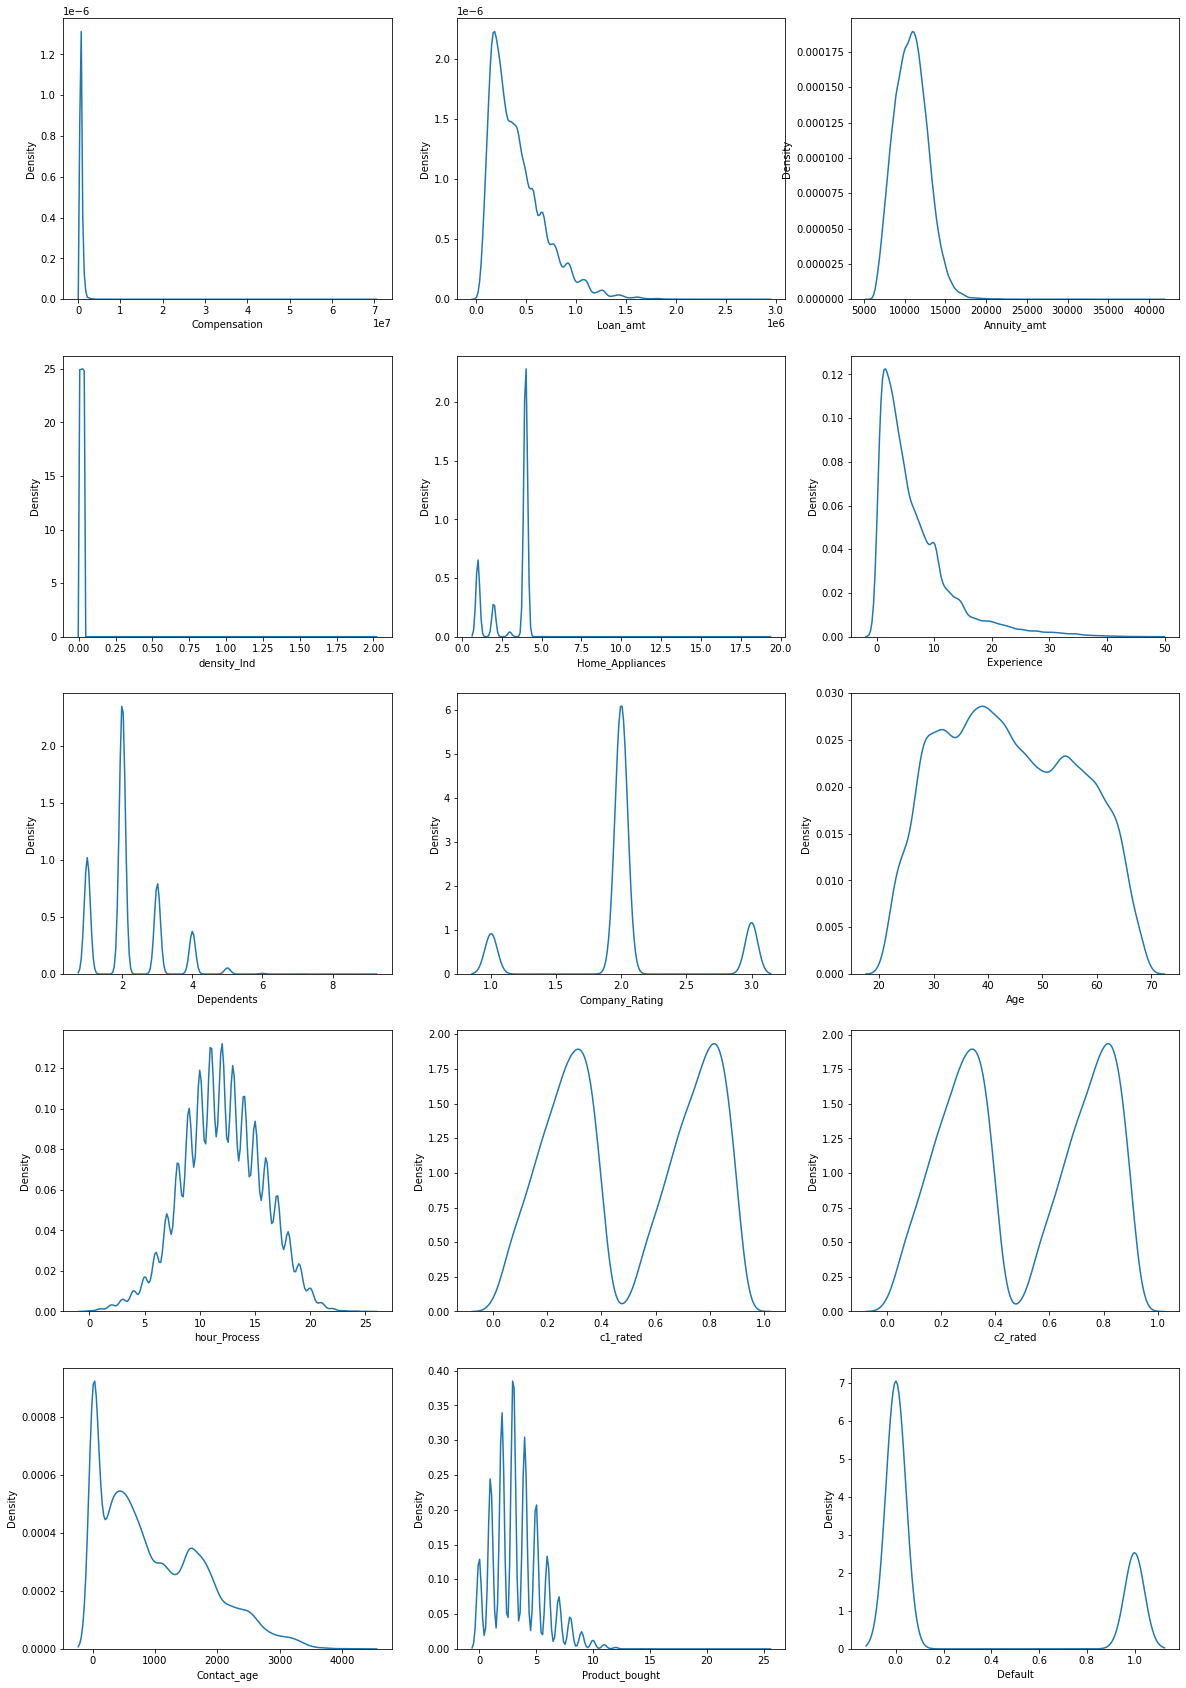

In [14]:
plt.figure(figsize=(20,30))
for n,i in enumerate(df.select_dtypes(exclude='O').columns):
    plt.subplot(5,3,n+1)
    sns.kdeplot(df[i])
plt.show()

We can see that the distributions are very skewed and show a lot of outliers. Let us check on how many outliers they have.

I have again defined a function to display the outliers in the variables.

In [41]:
def outlier_details(X,i):
    Q1 = X[i].quantile(0.25)
    Q3 = X[i].quantile(0.75)
    IQR = Q3-Q1
    Max = Q3 + 1.5*IQR
    Min = Q1 - 1.5*IQR
    print(f'The minimum and the maximum points beyond which outliers are present is {(Min,Max)}')
    print(f'There are {(X.shape[0]) - (X[~((X[i]<Min)|(X[i]>Max))].shape[0])} outliers present in {i} column \n')

In [42]:
for i in df.select_dtypes(exclude='O').columns:
    outlier_details(df,i)

The minimum and the maximum points beyond which outliers are present is (-24968.5, 1422163.5)
There are 5316 outliers present in Compensation column 

The minimum and the maximum points beyond which outliers are present is (-325982.62499999994, 1088717.575)
There are 3603 outliers present in Loan_amt column 

The minimum and the maximum points beyond which outliers are present is (5122.840000000003, 16390.92)
There are 1014 outliers present in Annuity_amt column 

The minimum and the maximum points beyond which outliers are present is (-0.0196, 0.060399999999999995)
There are 3 outliers present in density_Ind column 

The minimum and the maximum points beyond which outliers are present is (-1.0, 7.0)
There are 10 outliers present in Home_Appliances column 

The minimum and the maximum points beyond which outliers are present is (-8.250000000000002, 19.35)
There are 5938 outliers present in Experience column 

The minimum and the maximum points beyond which outliers are present is (0.5,

So there are quite some amound of outliers present in the columns. So we'll try to transform them using the power transformer, to reduce some amount of skewness.

<AxesSubplot:>

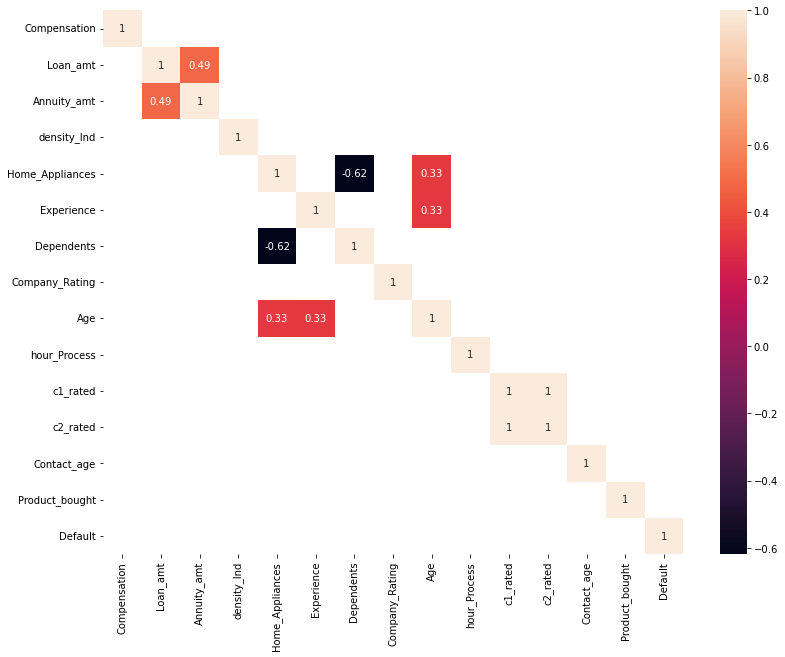

In [87]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr()[abs(df.corr())>0.3],annot=True)

There seems to be very minimal multicollinearity present, with the exception of home_appliances. So we'll remove the home appliances column.

In [88]:
X_train.drop(columns=['Home_Appliances'],axis=1,inplace=True)
X_test.drop(columns=['Home_Appliances'],axis=1,inplace=True)
test_df.drop(columns=['Home_Appliances'],axis=1,inplace=True)

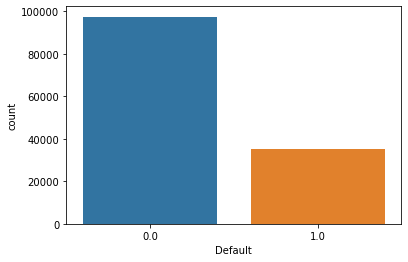

In [80]:
sns.countplot(df['Default'])
plt.show()

There seems to be a high data imbalance with this set, so we can try applying SMOTE on it.

In [89]:
smoted_x,smoted_y = SMOTE().fit_resample(X_train,y_train)

Transforming data:

In [ ]:
PT_X_train = X_train
PT_X_test = X_test

PT_smoted_x = smoted_x

from sklearn.preprocessing import PowerTransformer
PT = PowerTransformer()

for i in ['Compensation', 'Loan_amt', 'Annuity_amt', 'density_Ind','Age','hour_Process', 'c1_rated', 'c2_rated', 'Contact_age']:
    PT_X_train[i] = PT.fit_transform(X_train[[i]])
    PT_X_test[i]=PT.fit_transform(X_test[[i]]) 

Scaling the data:

In [104]:
from scipy.stats import zscore

In [105]:
scaled_train = zscore(PT_X_train)
scaled_test = zscore(PT_X_test)
scaled_smote = zscore(PT_smoted_x)

**Model Building**

I've created a function again, with 4 algorithms to check which model has the better f1 and recall scores, to tune it and build upon it. (Logistic Regression, Decision Tree, Random Forest and K-Nearest Neighbours). I'm considering only the recall here, since in default prediction, false negatives are more problematic than false postives.

We can choose whichever model has a better f1 score and recall and proceed to select features and tune it.

In [ ]:
recall_score(y_train,y_pred)

In [119]:
def models_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y):
    print('Logistic Regression, without SMOTE:')
    model = LogisticRegression().fit(X_train,y_train)
    y_pred = model.predict(X_train)
    print('\t The Logistic Regression Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')

    y_pred = model.predict(X_test)
    print('\t The Logistic Regression Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')    
    print('~~~~')
    
    print('Logistic Regression with SMOTE :')
    smoted_model = LogisticRegression().fit(smoted_x,smoted_y)
    y_pred = smoted_model.predict(X_train)
    print('\t The Logistic Regression Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
          
    y_pred = smoted_model.predict(X_test)
    print('\t The Logistic Regression Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')       
    print('X------------------------------------------X \n\n')
    
    print('Decision Tree, without SMOTE :')
    model = DecisionTreeClassifier(random_state=100).fit(X_train,y_train)
    y_pred = model.predict(X_train)
    print('\t The Decision Tree Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    y_pred = model.predict(X_test)
    print('\t The Decision Tree Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')
    print('~~~~')
    
    print('Decision Tree with SMOTE :')
    smoted_model = DecisionTreeClassifier(random_state=100).fit(smoted_x,smoted_y)
    y_pred = smoted_model.predict(X_train)
    print('\t The Decision Tree Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    y_pred = smoted_model.predict(X_test)
    print('\t The Decision Tree Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')    
    print('X------------------------------------------X \n\n')
    
    print('Random Forest, without SMOTE :')
    model = RandomForestClassifier(n_estimators=50,random_state=100).fit(X_train,y_train)
    y_pred = model.predict(X_train)
    print('\t The Random Forest Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    y_pred = model.predict(X_test)
    print('\t The Random Forest Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')
    print('~~~~')
    
    print('Random Forest with SMOTE :')
    smoted_model = RandomForestClassifier(n_estimators=50,random_state=100).fit(smoted_x,smoted_y)
    y_pred = smoted_model.predict(X_train)
    print('\t The Random Forest Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    
    y_pred = smoted_model.predict(X_test)
    print('\t The Random Forest Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')    
    print('X------------------------------------------X \n\n')
    
    
    
    scaled_train = zscore(X_train)
    scaled_test = zscore(X_test)
    scaled_smote = zscore(smoted_x)
    
    
    print('KNN, without SMOTE :')
    model = KNeighborsClassifier().fit(scaled_train,y_train)
    y_pred = model.predict(scaled_train)
    print('\t The KNN Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    
    y_pred = model.predict(scaled_test)
    print('\t The KNN Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n') 
    print('~~~~')
    
    print('KNN with SMOTE :')
    smoted_model = KNeighborsClassifier().fit(scaled_smote,smoted_y)
    y_pred = smoted_model.predict(scaled_train)
    print('\t The KNN Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    
    y_pred = smoted_model.predict(scaled_test)
    print('\t The KNN Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')    
    print('X------------------------------------------X \n\n')
    

In [120]:
models_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y)

Logistic Regression, without SMOTE:
	 The Logistic Regression Model train scores are 

Recall score of 1 is 0.0
F1_score of 1 is 0.0 

	 The Logistic Regression Model test scores are 

Recall score of 1 is 0.0
F1_score of 1 is 0.0 

~~~~
Logistic Regression with SMOTE :
	 The Logistic Regression Model train scores are 

Recall score of 1 is 0.5423420855748334
F1_score of 1 is 0.36135540917452974 

	 The Logistic Regression Model test scores are 

Recall score of 1 is 0.5379956741167988
F1_score of 1 is 0.3559265442404006 

X------------------------------------------X 


Decision Tree, without SMOTE :
	 The Decision Tree Model train scores are 

Recall score of 1 is 1.0
F1_score of 1 is 1.0 

	 The Decision Tree Model test scores are 

Recall score of 1 is 0.3016582552271089
F1_score of 1 is 0.28297037738401193 

~~~~
Decision Tree with SMOTE :
	 The Decision Tree Model train scores are 

Recall score of 1 is 0.5949980405429477
F1_score of 1 is 0.3696997199747645 

	 The Decision Tree M

SMOTE definitely improves the model performance, as we can all of the models with synthetic sampling increase the f1 and recall score of 1s. Almost all of the non-SMOTE models are overfitting or underfitting, which is bad.

Now we'll try with transformation

In [97]:
PT_X_train = X_train
PT_X_test = X_test

PT_smoted_x = smoted_x

from sklearn.preprocessing import PowerTransformer
PT = PowerTransformer()

for i in ['Compensation', 'Loan_amt', 'Annuity_amt', 'density_Ind','Age','hour_Process', 'c1_rated', 'c2_rated', 'Contact_age']:
    PT_X_train[i] = PT.fit_transform(X_train[[i]])
    PT_X_test[i]=PT.fit_transform(X_test[[i]])    

In [121]:
models_scores(PT_X_train,y_train,PT_X_test,y_test,PT_smoted_x,smoted_y)

Logistic Regression, without SMOTE:
	 The Logistic Regression Model train scores are 

Recall score of 1 is 0.0
F1_score of 1 is 0.0 

	 The Logistic Regression Model test scores are 

Recall score of 1 is 0.0
F1_score of 1 is 0.0 

~~~~
Logistic Regression with SMOTE :
	 The Logistic Regression Model train scores are 

Recall score of 1 is 0.5423420855748334
F1_score of 1 is 0.36135540917452974 

	 The Logistic Regression Model test scores are 

Recall score of 1 is 0.5379956741167988
F1_score of 1 is 0.3559265442404006 

X------------------------------------------X 


Decision Tree, without SMOTE :
	 The Decision Tree Model train scores are 

Recall score of 1 is 1.0
F1_score of 1 is 1.0 

	 The Decision Tree Model test scores are 

Recall score of 1 is 0.3016582552271089
F1_score of 1 is 0.28297037738401193 

~~~~
Decision Tree with SMOTE :
	 The Decision Tree Model train scores are 

Recall score of 1 is 0.5949980405429477
F1_score of 1 is 0.3696997199747645 

	 The Decision Tree M

Transformation doesn't really have any effect on the data.

MODEL 1

We'll snip out a part of the code I had defined for Logistic regression, perform feature selection, and then tune it further. I'll be doing this for all the models.

In [122]:
def Log_Reg_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y):
    smoted_model = LogisticRegression().fit(smoted_x,smoted_y)
    y_pred = smoted_model.predict(X_train)
    print('\t The Logistic Regression Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
          
    y_pred = smoted_model.predict(X_test)
    print('\t The Logistic Regression Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')

In [123]:
Log_Reg_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y)

	 The Logistic Regression Model train scores are 

Recall score of 1 is 0.5423420855748334
F1_score of 1 is 0.36135540917452974 

	 The Logistic Regression Model test scores are 

Recall score of 1 is 0.5379956741167988
F1_score of 1 is 0.3559265442404006 



In [134]:
SFS(estimator = LogisticRegression(),k_features=9,scoring='f1').fit(smoted_x,smoted_y).k_feature_names_

('density_Ind',
 'Job_Type',
 'Default_hist',
 'Prop_List',
 'Region_Type',
 'Credit_Inq',
 'Education_det',
 'Type_Loan',
 'Contact_age')

In [147]:
vv = ['density_Ind',
 'Job_Type',
 'Default_hist',
 'Prop_List',
 'Region_Type',
 'Credit_Inq',
 'Education_det',
 'Type_Loan',
 'Contact_age']

In [136]:
Log_Reg_scores(X_train[vv],y_train,X_test[vv],y_test,smoted_x[vv],smoted_y)

	 The Logistic Regression Model train scores are 

Recall score of 1 is 0.8179486265987388
F1_score of 1 is 0.4011041326356799 

	 The Logistic Regression Model test scores are 

Recall score of 1 is 0.8187454938716655
F1_score of 1 is 0.3981348385513445 



In [161]:
def Boost_scores(base_estimator,feature_list):
    AdaModel = AdaBoostClassifier(base_estimator=base_estimator,random_state=100).fit(smoted_x[feature_list],smoted_y)
    y_pred = AdaModel.predict(X_train[feature_list])
    print(f'The Train F1 score of AdaBoost is {f1_score(y_train,y_pred)}')
    print(f'The Train Recall score of AdaBoost is {recall_score(y_train,y_pred)} \n')
    y_pred = AdaModel.predict(X_test[feature_list])
    print(f'The Test F1 score of AdaBoost is {f1_score(y_test,y_pred)}')
    print(f'The Test Recall score of AdaBoost is {recall_score(y_test,y_pred)} \n\n')
    
    
    print('_________________________________________________________ \n')
    print('_________________________________________________________ \n')
    
    
    
    
    XGBModel = XGBClassifier().fit(smoted_x[feature_list],smoted_y)
    y_pred = XGBModel.predict(X_train[feature_list])
    print(f'The Train F1 score of XGBoost is {f1_score(y_train,y_pred)}')
    print(f'The Train Recall score of XGBoost is {recall_score(y_train,y_pred)} \n')
    y_pred = XGBModel.predict(X_test[feature_list])
    print(f'The Test F1 score of XGBoost is {f1_score(y_test,y_pred)}')
    print(f'The Test Recall score of XGBoost is {recall_score(y_test,y_pred)} \n\n')
    
    

In [163]:
Boost_scores(LogisticRegression(),vv)

The Train F1 score of AdaBoost is 0.4011041326356799
The Train Recall score of AdaBoost is 0.8179486265987388 

The Test F1 score of AdaBoost is 0.3981348385513445
The Test Recall score of AdaBoost is 0.8187454938716655 


_________________________________________________________ 

_________________________________________________________ 

The Train F1 score of XGBoost is 0.03590949746579653
The Train Recall score of XGBoost is 0.01930955858776586 

The Test F1 score of XGBoost is 0.2312111434642323
The Test Recall score of XGBoost is 0.21182408074981976 




Boosting the scores wasn't as fruitful.

In [170]:
LogReg_pred = LogisticRegression().fit(smoted_x[vv],smoted_y).predict(test_df[vv])

In [171]:
LogReg_pred

array([0., 1., 1., ..., 0., 1., 1.])

Model 2

In [173]:

def RandomForest_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y):
    print('Random Forest, without SMOTE :')
    model = RandomForestClassifier(n_estimators=50,random_state=100).fit(X_train,y_train)
    y_pred = model.predict(X_train)
    print('\t The Random Forest Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    y_pred = model.predict(X_test)
    print('\t The Random Forest Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')
    print('~~~~')
    
    print('Random Forest with SMOTE :')
    smoted_model = RandomForestClassifier(n_estimators=50,random_state=100).fit(smoted_x,smoted_y)
    y_pred = smoted_model.predict(X_train)
    print('\t The Random Forest Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    
    y_pred = smoted_model.predict(X_test)
    print('\t The Random Forest Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')    
    print('X------------------------------------------X \n\n')

In [174]:
RandomForest_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y)

Random Forest, without SMOTE :
	 The Random Forest Model train scores are 

Recall score of 1 is 0.9994656026221098
F1_score of 1 is 0.9997327298968337 

	 The Random Forest Model test scores are 

Recall score of 1 is 0.004758471521268926
F1_score of 1 is 0.009396355353075172 

~~~~
Random Forest with SMOTE :
	 The Random Forest Model train scores are 

Recall score of 1 is 0.23780683316113863
F1_score of 1 is 0.2767412935323383 

	 The Random Forest Model test scores are 

Recall score of 1 is 0.5202595529920692
F1_score of 1 is 0.346539883782356 

X------------------------------------------X 




In [176]:
vv  = SFS(estimator = RandomForestClassifier(),k_features=10,scoring='f1').fit(smoted_x,smoted_y).k_feature_names_


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
Boost_scores(RandomForestClassifier(),vv)

In [ ]:
Random_Forest_pred = RandomForestClassifier().fit(smoted_x[vv],smoted_y).predict(test_df[vv])
Random_Forest_pred

Model 3

In [177]:
def KNN_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y):  
    scaled_train = zscore(X_train)
    scaled_test = zscore(X_test)
    scaled_smote = zscore(smoted_x)
    
    
    print('KNN, without SMOTE :')
    model = KNeighborsClassifier().fit(scaled_train,y_train)
    y_pred = model.predict(scaled_train)
    print('\t The KNN Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    
    y_pred = model.predict(scaled_test)
    print('\t The KNN Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n') 
    print('~~~~')
    
    print('KNN with SMOTE :')
    smoted_model = KNeighborsClassifier().fit(scaled_smote,smoted_y)
    y_pred = smoted_model.predict(scaled_train)
    print('\t The KNN Model train scores are \n')
    print(f'Recall score of 1 is {recall_score(y_train,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_train,y_pred)} \n')
    
    
    y_pred = smoted_model.predict(scaled_test)
    print('\t The KNN Model test scores are \n')
    print(f'Recall score of 1 is {recall_score(y_test,y_pred)}')
    print(f'F1_score of 1 is {f1_score(y_test,y_pred)} \n')    
    print('X------------------------------------------X \n\n')
    

In [ ]:
KNN_scores(X_train,y_train,X_test,y_test,smoted_x,smoted_y)

Descriptive Section:

We can see that thegoal of the intitution is to predict if the customer might default, so I'm going in with calculating the F1 score to check if the model is handy or not. I've also considered the Recall of the model to verify it's  integrity.

The next steps in the modelbuilding are to improve by applying GridSearch CV and finetuning the hyper parmeter, which my computer has been unable to handle.